# Question Classification

## Load word2vec models

#### Load the word2vec models

In [5]:
import gensim
from gensim.models import KeyedVectors

In [4]:
%%time
pt_w2v_patch = 'data/word_embedding/cbow_s300.txt'
pt_w2v = KeyedVectors.load_word2vec_format(pt_w2v_patch, unicode_errors="ignore")
pt_model_w2v = {w: vec for w, vec in zip(pt_w2v.index2word, pt_w2v.syn0)}
del pt_w2v

C:\Users\55519\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 3min 34s


In [2]:
%%time
en_w2v_patch = 'data/word_embedding/GoogleNews-vectors-negative300.bin'
en_w2v = gensim.models.Word2Vec.load_word2vec_format(en_w2v_patch, binary=True)
en_model_w2v = {w: vec for w, vec in zip(en_w2v.index2word, en_w2v.syn0)}
del en_w2v

NameError: name 'gensim' is not defined

## Util

#### Separete the questions in data (X) and label (y)

In [9]:
def separete_questions(questions, label_key='class'):
    X = []
    y = []
    for question in questions:
        text = question['question']
        X.append(text)
        y.append(question[label_key])
    return X, y

####  Ignore all warnings

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Create Models

#### SVM



In [21]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import qc_models as QCM 

def svm_bow_model():
    return Pipeline([("vector_model", QCM.count_vectorizer()), ("classifer", LinearSVC())])

def svm_tfidf_model():
    return Pipeline([("vector_model", QCM.tfidf_vectorizer()), ("classifer", LinearSVC())])

def svm_w2v_model(w2v):
    return Pipeline([("vector_model", QCM.MeanEmbeddingVectorizer(w2v)), ("classifer", LinearSVC())])

def svm_hybrid_model(w2v):
    return Pipeline([("vector_model", QCM.TfidfHybridVectorizer(w2v)), ("classifer", LinearSVC())])

#### LSTM

#### CNN

## Chave

In [ ]:
import datasets_manager as DM


chave = DM.chave_questions()

### Data pre-processing

#### Remove questions with incosiderate class

In [ ]:
incosiderate_classes=['X', 'MANNER', 'OBJECT', 'OTHER', 'DEFINITION']
ret = []
for question in chave:
    if question['class'] is not None and question['class'] not in incosiderate_classes:
        ret.append(question)
chave = ret

#### Remove questions with no text in question text

In [ ]:
ret = []
for question in chave:
    if question['question'] is None or question['question'].strip() == '':
        continue
    ret.append(question)
chave = ret

#### X and y

In [ ]:
chave_X, chave_y = separete_questions(chave)

### Models

In [ ]:
models = [
    {'name': 'SVM BoW', 'model': svm_bow_model()},
    {'name': 'SVM TF-IDF', 'model': svm_tfidf_model()},
    #{'name': 'SVM W2V', 'model': svm_w2v_model()},
    #{'name': 'SVM Hybrid', 'model': svm_hybrid_model()},
]

### Train and Test

In [ ]:
%%time
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

X = np.array(chave_X)
y = np.array(chave_y)
n = 40  # Training size interval
k = 5  # k-folds
minimum_test = 200

size_train = 0
results = []

while (size_train + n) <= (len(X) - minimum_test):
    size_train += n
    size_test = len(X) - size_train
    print ('\nTrain:', size_train, 'Test:', size_test, end=': ')
    rs = ShuffleSplit(n_splits=k, train_size=size_train, test_size=size_test, random_state=0)
    for model in models:
        print(' ', model['name'], end=' ')
        accuracy = []
        precision = []
        recall = []
        f1 = []
        confusion = []
        for train_indexs, test_indexs in rs.split(X):
            print('.', end='')
            x_train = X[train_indexs]
            y_train = y[train_indexs]
            x_test = X[test_indexs]
            y_test = y[test_indexs]
            
            model_ = model['model'].fit(x_train, y_train)
            result = model_.predict(x_test)
            score = {}
            accuracy.append(accuracy_score(result, y_test))
            precision.append(precision_score(result, y_test, average="macro"))
            recall.append(recall_score(result, y_test, average="macro"))
            f1.append(f1_score(result, y_test, average="macro"))
            confusion.append(confusion_matrix(result, y_test))
        
        results.append({'Model': model['name'], 
                      'accuracy': np.mean(accuracy),
                      'precision': np.mean(precision),
                      'recall': np.mean(recall),
                      'f1': np.mean(f1),
                      'confusion': np.mean(confusion, axis=0),
                      'train_size': size_train})
print('')

### Show Results

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

names = [model['name'] for model in models]
df = pd.DataFrame(results)

aux = df[df.Model.map(lambda x: x in names)]

sorterIndex = dict(zip(names, range(len(names))))
aux['models_sort'] = aux['Model'].map(sorterIndex)
aux.sort_values(['Model'], \
        ascending = [1], inplace = True)
aux.drop('models_sort', 1, inplace = True)


col_list = ["black", "black", "black", "black", "black"]
col_list_palette = sns.xkcd_palette(col_list)
#sns.set_palette(col_list_palette)
sns.set_palette(sns.color_palette("muted", 5))


#df = df.drop('accuracy', 1).drop('precision', 1).drop('recall', 1).drop('train_size', 1)

plt.figure(figsize=(8, 4))

fig = sns.pointplot(x='train_size', y='f1', hue='Model', 
                    data=df[df.Model.map(lambda x: x in names)],
                    #markers=['o',7,'p','s','x'],
                    markers=['','','','',''],
                    lineheight=1
                   )

for ind, label in enumerate(fig.get_xticklabels()):
    if ind == 0 or ind == 12 or ind == 26 or ind == 39 or ind == 52:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(fig.lines,linewidth=1.5)
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="f1")
fig.set(xlabel="Size of the training sample")
fig.set(ylabel="F1-Score")

## UIUC PT

In [7]:
import datasets_manager as DM


uiuc_pt_train, uiuc_pt_test = DM.uiuc_pt_questions()

#### X and y

In [12]:
uiuc_pt_train_X, uiuc_pt_train_y = separete_questions(uiuc_pt_train)
uiuc_pt_test_X, uiuc_pt_test_y = separete_questions(uiuc_pt_test)

### Models

In [22]:
models = [
    {'name': 'SVM BoW', 'model': svm_bow_model()},
    {'name': 'SVM TF-IDF', 'model': svm_tfidf_model()},
    {'name': 'SVM W2V', 'model': svm_w2v_model(pt_model_w2v)},
    {'name': 'SVM Hybrid', 'model': svm_hybrid_model(pt_model_w2v)},
]

### Train and Test

In [23]:
%%time
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

X_train = np.array(uiuc_pt_train_X)
y_train = np.array(uiuc_pt_train_y)
X_test = np.array(uiuc_pt_test_X)
y_test = np.array(uiuc_pt_test_y)
n = 40  # Training size interval
k = 5
minimum_test = 800

size_train = 0
results = []

while (size_train + n) <= (len(X_train) - minimum_test):
    size_train += n
    size_test = len(X_train) - size_train
    print ('\nTrain:', size_train, 'Test:', size_test, end=': ')
    rs = ShuffleSplit(n_splits=k, train_size=size_train, test_size=size_test, random_state=0)
    for model in models:
        print(' ', model['name'], end=' ')
        accuracy = []
        precision = []
        recall = []
        f1 = []
        confusion = []
        for train_indexs, test_indexs in rs.split(X_train):
            print('.', end='')
            x_train_ = X_train[train_indexs]
            y_train_ = y_train[train_indexs]
            
            model_ = model['model'].fit(x_train_, y_train_)
            result = model_.predict(X_test)
            score = {}
            accuracy.append(accuracy_score(result, y_test))
            precision.append(precision_score(result, y_test, average="macro"))
            recall.append(recall_score(result, y_test, average="macro"))
            f1.append(f1_score(result, y_test, average="macro"))
            confusion.append(confusion_matrix(result, y_test))
        
        results.append({'Model': model['name'], 
                      'accuracy': np.mean(accuracy),
                      'precision': np.mean(precision),
                      'recall': np.mean(recall),
                      'f1': np.mean(f1),
                      'confusion': np.mean(confusion, axis=0),
                      'train_size': size_train})
print('')


Train: 40 Test: 5417:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 80 Test: 5377:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 120 Test: 5337:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 160 Test: 5297:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 200 Test: 5257:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 240 Test: 5217:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 280 Test: 5177:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 320 Test: 5137:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 360 Test: 5097:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 400 Test: 5057:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 440 Test: 5017:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 480 

Train: 3640 Test: 1817:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3680 Test: 1777:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3720 Test: 1737:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3760 Test: 1697:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3800 Test: 1657:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3840 Test: 1617:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3880 Test: 1577:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3920 Test: 1537:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 3960 Test: 1497:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 4000 Test: 1457:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....
Train: 4040 Test: 1417:   SVM BoW .....  SVM TF-IDF .....  SVM W2V .....  SVM Hybrid .....

### Show Results

[Text(0,0.5,'F1-Score')]

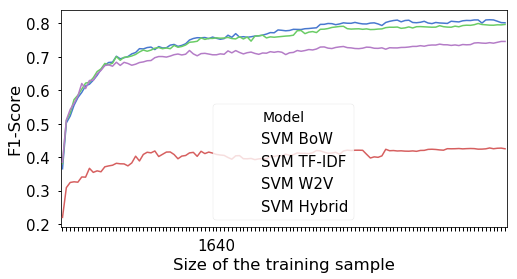

In [39]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

names = [model['name'] for model in models]
df = pd.DataFrame(results)

aux = df[df.Model.map(lambda x: x in names)]

sorterIndex = dict(zip(names, range(len(names))))
aux['models_sort'] = aux['Model'].map(sorterIndex)
aux.sort_values(['Model'], \
        ascending = [1], inplace = True)
aux.drop('models_sort', 1, inplace = True)


col_list = ["black", "black", "black", "black", "black"]
col_list_palette = sns.xkcd_palette(col_list)
#sns.set_palette(col_list_palette)
sns.set_palette(sns.color_palette("muted", 4))


#df = df.drop('accuracy', 1).drop('precision', 1).drop('recall', 1).drop('train_size', 1)

plt.figure(figsize=(8, 4))

fig = sns.pointplot(x='train_size', y='f1', hue='Model', 
                    data=df[df.Model.map(lambda x: x in names)],
                    #markers=['o',7,'p','s','x'],
                    markers=['','','','',''],
                    lineheight=1
                   )

total_ = len(uiuc_pt_train_X)
s0 = 40
s1 = int(1*(total_/4))
s2 = int(2*(total_/4))
s3 = int(3*(total_/4))
s4 = total_

for ind, label in enumerate(fig.get_xticklabels()):
    if ind == s0 or ind == s1 or ind == s2 or ind == s3 or ind == s4:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(fig.lines,linewidth=1.5)
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="f1")
fig.set(xlabel="Size of the training sample")
fig.set(ylabel="F1-Score")

## UIUC

In [ ]:
import datasets_manager as DM


uiuc_train, uiuc_test = DM.uiuc_questions()